<a href="https://colab.research.google.com/github/LeeSeungwon89/Lecture-and-self-study/blob/master/5-1%20%EA%B2%B0%EC%A0%95%20%ED%8A%B8%EB%A6%AC(%EC%A0%95%EB%A6%AC%20%EC%A4%91).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 결정 트리

## 로지스틱 회귀로 와인 분류하기

### 데이터 준비

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
print(wine)
# 총 샘플 6496개로 이루어진 판다스 데이터프레임이며,
# 네 번째 열은 타깃값으로 0(음성 클래스)이면 레드 와인, 1(양성 클래스)이면 화이트 와인임.
# 즉 화이트 와인을 골라내는 문제임.

      alcohol  sugar    pH  class
0         9.4    1.9  3.51    0.0
1         9.8    2.6  3.20    0.0
2         9.8    2.3  3.26    0.0
3         9.8    1.9  3.16    0.0
4         9.4    1.9  3.51    0.0
...       ...    ...   ...    ...
6492     11.2    1.6  3.27    1.0
6493      9.6    8.0  3.15    1.0
6494      9.4    1.2  2.99    1.0
6495     12.8    1.1  3.34    1.0
6496     11.8    0.8  3.26    1.0

[6497 rows x 4 columns]


In [2]:
# info() 메서드를 사용하여 누락된 데이터가 있는지 확인함.
wine.info()
# 누락된 값은 없음.
# 만약 누락된 값이 있다면 그 데이터를 버리거나 평균값으로 채우고 사용함.
# 최선의 방법이 정해진 건 아니므로 두 방법 모두 사용해보고 최선을 택함..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [3]:
# describe() 메서드를 사용하여 열에 대한 간략한 통계를 출력함.
wine.describe()
# 개수, 평균, 표준편차, 최소, 최대, 1사분위수 ~ 최대까지 알려줌.
# 만약 데이터 개수가 짝수개라서 중앙값을 선택하기 어려운 경우는 가운데 값 2개의 평균을 사용함.
# 각 특성의 스케일이 다르므로 StandardScaler 클래스를 사용하여 특성을 표준화 전처리 해야 함.

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [4]:
# 판다스 데이터프레임을 넘파이 배열로 바꾸고, 훈련 세트와 테스트 세트로 나눔.
data = wine[['alcohol', 'sugar', 'pH']].to_numpy() # 특성만 골라서 2차원 리스트로 만듦.
print(data)

target = wine['class'].to_numpy() # 타깃만 골라서 1차원 리스트로 만듦.
print(target)

from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)
# test_size 매개변수의 기본값은 0.25(25%). 샘플 개수가 충분히 많으므로 0.2로 지정함.

print(train_input.shape, test_input.shape)

[[ 9.4   1.9   3.51]
 [ 9.8   2.6   3.2 ]
 [ 9.8   2.3   3.26]
 ...
 [ 9.4   1.2   2.99]
 [12.8   1.1   3.34]
 [11.8   0.8   3.26]]
[0. 0. 0. ... 1. 1. 1.]
(5197, 3) (1300, 3)


In [5]:
# StandardScaler 클래스를 사용하여 훈련 세트를 전처리 함.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

print(train_scaled, test_scaled)

[[ 0.01376574  0.4646116  -0.16888369]
 [ 1.60871671 -0.70299854  0.26967864]
 [ 1.10504798 -0.70299854  1.20945505]
 ...
 [-0.82568214  0.0267578   0.14437512]
 [-0.82568214  0.52716215 -0.23153545]
 [-0.82568214 -0.57789745  1.83597265]] [[ 1.44082714  1.52797084  0.26967864]
 [-0.48990299 -0.68214836  0.3323304 ]
 [ 1.27293756  0.40206106 -0.23153545]
 ...
 [ 1.60871671 -0.76554908 -0.16888369]
 [-0.90962693  0.88161523  0.52028568]
 [-1.49724045  2.09092573 -1.98578474]]


### 로지스틱 회귀 모델 훈련하기

In [6]:
# 로지스틱 회귀 모델을 훈련함.
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))
# 과소적합 상태임.
# c(규제를 제어하는 매개변수) 값을 바꿔서 규제를 조절하거나,
# solver(알고리즘을 선택하는 매개변수) 값을 바꿔서 다른 알고리즘을 선택하거나,
# 다항 특성을 추가할 수 있음.

0.7808350971714451
0.7776923076923077


In [7]:
# 계수와 절편을 확인함.
print(lr.coef_, lr.intercept_)
# y = (alcohol * 0.51) + (sugar * 1.67) + (pH * -0.69) + 1.82
# y > 0 -> 화이트 와인(1), y < 0 -> 레드 와인(0)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


## 결정 트리

- 사이킷런이 제공하는 알고리즘으로 분류 클래스인 'DecisionTreeClassifier'과 회귀 클래스인 'DecisionTreeRegressor'를 사용함.

- 출력값에 대하여 메커니즘을 설명하기 쉬운 모델.

- 스무고개처럼 질문을 여러번 추가하여 분류 정확도를 높일 수 있음.

- 사용법은 사이킷런의 다른 클래스들과 동일함.

아래에서 이어서 설명함.

### 결정 트리 모델 만들기

In [8]:
# 결정 트리 모델을 만들고 정확도를 파악함.
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42)
# 결정 트리 알고리즘은 실행할 때마다 점수가 조금씩 달라질 수 있으므로
# 노드에서 최적의 분할을 찾기 전에 먼저 특성의 순서를 섞음.
# 여기에서는 실습 결과와 교재 내용이 같게 만들고자 random_state = 42 로 지정함.(실전에서는 지정할 필요 없음.)

dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 과대적합된 모델임.

0.996921300750433
0.8592307692307692


### 결정 트리 모델을 그림으로 출력하기

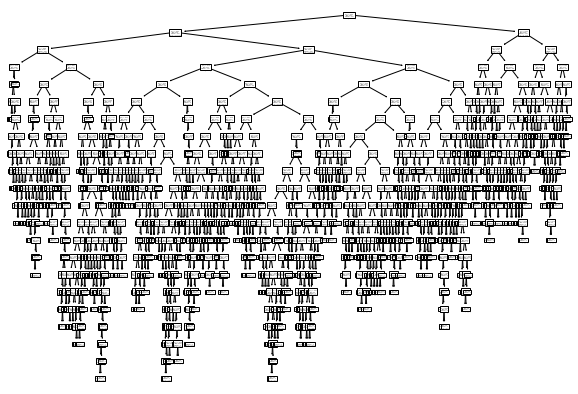

In [9]:
# 결정 트리 모델을 그림으로 출력함.
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree # plot_tree(): 트리 모델을 그림으로 출력하는 함수

plt.figure(figsize = (10, 7)) # 가로 10, 세로 7로 나타냄.

plot_tree(dt) # 결정 트리 모델 객체를 plot_tree() 함수에 전달함.

plt.show()
# 노드(node)는 사전적 의미로 '(줄기의)마디'를 의미하며, '교점', '접속점'을 의미함.
# 결정 트리에서 노드는 훈련 데이터의 특성에 대한 테스트를 표현함. e.g. 당도가 -0.239보다 작거나 같은지 테스트함.
# 맨 위의 네모난 상자를 루트 노드(root node), 맨 아래 끝에 달린 네모난 상자를 리프 노드(leaf node)라고 함.
# 네모난 상자 아래 선은 가지(branch)이며 테스트의 결과(True, False)를 나타냄.
# 일반적으로 하나의 노드는 2개의 가지를 가짐.

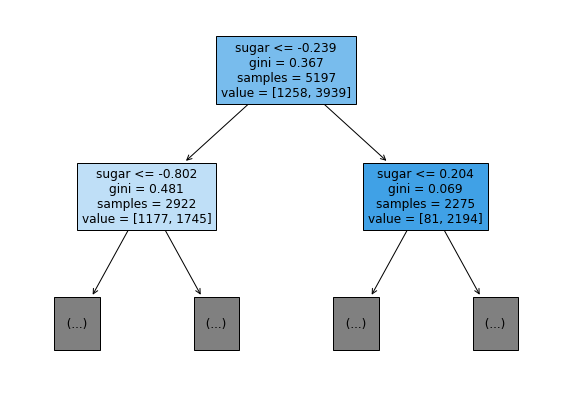

In [10]:
# 트리 깊이를 제한하여 출력함.
plt.figure(figsize = (10, 7))

plot_tree(dt, max_depth = 1, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
# max_depth: 노드의 깊이를 지정하는 매개변수. 1로 지정하면 루트 노드를 제외하고 하나의 노드를 그림. 2로 지정하면 두 개의 노드를 그림.
# filled: 클래스의 비중에 맞추어 노드의 색을 칠하는 매개변수. 기본값은 False.
# feature_names: 특성의 이름을 전달하는 매개변수. 지정하지 않으면 X[1] 같은 식으로 표현됨.

plt.show()
# 1. 루트 노드
# sugar가 -0.239 이하인지 질문함. 어떤 샘플의 sugar가 -0.239 이하라면(True) 왼쪽 노드로 이동하고, 아니라면(False) 오른쪽 노드로 이동함.
# gini는 지니 불순도(Gini impurity)를 의미함. 아래에서 따로 상세하게 설명함.
# samples은 총 샘플 수(5,197개)를 나타냄.
# value는 음성 클래스(레드 와인) 1,258개, 양성 클래스(화이트 와인) 3,939개를 나타냄.

# 2. 왼쪽 노드
# 루트 노드와 달리 sugar가 더 낮은지 질문함. 여기서도 True이면 왼쪽 노드로 이동하고, False이면 오른쪽 노드로 이동함.
# samples와 value는 루트 노드와 다른 수치를 나타냄. 루트 노드보다 양성 클래스의 비율이 크게 줄어듦.

# 3. 오른쪽 노드
# 음성 클래스가 81개, 양성 클래스가 2,194개로 대부분의 양성 클래스(화이트 와인)가 여기 노드로 이동함.
# 여기 노드의 바탕 색깔은 루트 노드보다 더 진하고, 왼쪽 노드의 바탕 색깔은 여기 노드보다 더 연함.
# 어떤 클래스의 비율이 높아지면 점점 진한 색으로 표시됨.

# 4. 결론
# 리프 노드에서 가장 많은 클래스가 예측 클래스임.(k-최근접 이웃과 비슷함.)
# 만약 이 결정 트리의 성장을 여기서 멈추면 왼쪽 노드와 오른쪽 노드 모두 양성 클래스의 개수가 많기 때문에 양성 클래스로 예측함.
# 회귀의 경우 'DecisionTreeRegressor' 클래스를 사용함. 리프 노드에 도달한 샘플의 타깃을 평균하여 예측값으로 사용함.

### 불순도

- 결정 트리가 최적의 질문을 찾기 위한 기준.

- 지니 불순도(Gini impurity) -> 위 트리를 예시로 설명함.

   - 위 트리의 노드에서 'gini'를 의미함.

   - 'DecisionTreeClassifier' 클래스에서 'criterion' 매개변수의 용도는 노드에서 데이터를 분할할 기준을 정하는 것이며, 기본값은 'gini'임.

   - 지니 불순도 = 1 - (음성 클래스 비율$^2$ + 양성 클래스 비율$^2$)

   - 루트 노드의 지니 불순도
   
    - 1 - ((1258 / 5197)$^2$ + (3939 / 5197)$^2$) = 0.367

   - 100개의 샘플 중에 클래스 비율이 1/2씩이라면 0.5가 되어 최악임.

    - 1 - ((50 / 100)$^2$ + (50 / 100)$^2$) = 0.5

   - 클래스가 하나만 있다면 0이 되어 가장 작음.(순수 노드)

    - 1 - ((0 / 100)$^2$ + (100 / 100)$^2$) = 0

   - 결정 트리 모델은 부모 노드(parent node)와 자식 노드(children node)의 불순도 차이(정보 이득(information gain))가 가능한 크도록 트리를 성장시킴. 다시 말하면, 결정 트리 알고리즘은 정보 이득이 최대가 되도록 데이터를 나누는 게 목적임.
   
   위 트리를 예시로 계산식을 설명함.

    - 부모 노드와 자식 노드의 불순도 차이(정보 이득) = 부모의 불순도 - (왼쪽 노드 샘플 수 / 부모 노드 샘플 수) * 왼쪽 노드 불순도 - (오른쪽 노드 샘플 수 / 부모 노드 샘플 수) * 오른쪽 노드 불순도

    - 부모 노드와 자식 노드의 불순도 차이(정보 이득) = 0.367 - (2922 / 5197) * 0.481 - (2275 / 5197) * 0.069 = 0.066

- 엔트로피 불순도(Entrophy impurity)

   - 휴식 중..

### 가지치기